## Layered API 

Using the high-level api: just create the data loaders for me using all your defaults. 

This works well if your data is arranged in a particular way, which it won't always be 

In [165]:
from fastai.text.all import * 

In [166]:
# note how this is caches at .fastai/data if you've already downloaded it 
path = untar_data(URLs.IMDB); path 

Path('/home/jupyter/.fastai/data/imdb')

In [167]:
dls = TextDataLoaders.from_folder(path, valid='test')  

In [168]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj okay , so xxmaj i 'm not a big video game buff , but was the game xxmaj house of the xxmaj dead really famous enough to make a movie from ? xxmaj sure , they went as far as to actually put in quick video game clips throughout the movie , as though justifying any particular scene of violence , but there are dozens and dozens of games that look exactly the same , with the hand in the bottom on the screen , supposedly your own , holding whatever weapon and goo - ing all kinds of aliens or walking dead or snipers or whatever the case may be . \n\n xxmaj it 's an interesting premise in xxmaj house of the xxmaj dead , with a lot of college kids ( loaded college kids , as it were , kids who are able to pay",neg
2,"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact , the last part is actually what happens to xxmaj dave and xxmaj andrew , two room - mates living in a run - down house in the middle of a freeway system . xxmaj andrew is a nervous wreck to say the least and xxmaj dave is considered being one of the biggest losers of society . xxmaj that alone is the main reason to why these two guys get so well along , because they simply only have each",pos


The dataloader now contains the transformed datasets for training and validation. Each item in the dataset is a tensor of transformed inputs and outputs

In [169]:
dls.train.dataset[:1], dls.valid.dataset[:1]

([(TensorText([    2,    19,   143,    20,    32,    15,  3487,  1505,    18,
                2203,    12,  1946,  1139,   108,   115,  3255,    39,  3993,
                 100,     8,   157,  1350,    61,   467,  7568,    16,   637,
                  12,    80,   733,    60,     9,  1318,  7107,    48,     9,
               13277,    10,     8,   157,  2124,    14,     9,  3481,    12,
                2124,    14,  2203,    39,  3378,    15,  9255,    10,     8,
                  20,    16,    13,   225,    24,    86,    84,    14,   110,
               15370,    25,   824,    15,     9,   688,    14,     9,   196,
                 165,     9, 22937,    14,     8,  2092,     8, 11950,    12,
                   9, 12205,    14,     8,  2468,     8,  1573,    10,     8,
                  17,   105,   426,    49,   637,  2184,    14,   875,  2203,
                 100,    22,    33,    80,  2231,    61,    13,  7868,    11,
                  31,    33,   197,    36,  2231,    61,    13, 

In [170]:
TextDataLoaders.from_folder??

Signature:
TextDataLoaders.from_folder(
    path,
    train='train',
    valid='valid',
    valid_pct=None,
    seed=None,
    vocab=None,
    text_vocab=None,
    is_lm=False,
    tok_tfm=None,
    seq_len=72,
    splitter=None,
    backwards=False,
    *,
    bs: 'int' = 64,
    val_bs: 'int' = None,
    shuffle: 'bool' = True,
    device=None,
)
Source:   
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None, seed=None, vocab=None, text_vocab=None, is_lm=False,
                    tok_tfm=None, seq_len=72, splitter=None, backwards=False, **kwargs):
        "Create from imagenet style dataset in `path` with `train` and `valid` subfolders (or provide `valid_pct`)"
        if splitter is None:
            splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        blocks = [TextBlock.from_folder(path, text_vocab, is_lm, seq_len, b

We used: 
- default tokenizing of text 
- default label is the parent directory of a given file

We can get the same results by using the data block API more explicitly: 

In [171]:
dls = DataBlock(
    # how to transform features and labels. text -> tokens -> numbers. label -> integer     
    blocks=(TextBlock.from_folder(path), CategoryBlock),
    # how to get a label from the input file path     
    get_y=parent_label,
    # how to get the input data from an input path (find any text files under the train or test dirs) 
    get_items=partial(get_text_files, folders=['train','test']),
    # how to split the data between training and validation sets     
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path)

Blocks are there essentially to encode a transformation or set of transformations on your raw input data. e.g. for text, we need to tokenize the whole corpus, get the vocab size, map each token to a number etc. 

## Transforms  

How does fastai figure out how to get back to the original text from the transformed data? Each transform has an "encode" and "decode" method.  

In [172]:
files = get_text_files(path, folders=['test','train']) 
txts = L(f.open().read() for f in files[:2000])
txts[0]

"This movie was a modern day scarface.It had me on my toes.This movie is one of those rare epic films that makes you want a sequel.I especially liked Damian Chapa his performance deserved an academy award,which he deserved for his performance in blood in blood out.The only thing I didn't like was the behind the scenes because it didn't show the intensity that the movie had,and i would have like to have seen less narrated scenes.But the movie was great and it is in my top ten movies of all time.Plus the acting was great there wasn't a bad scene in the movie,I loved it ,Jennifer Tilly was perfect as well as all of the cast.I can't see how anyone wouldn't like this movie it was a great.Definitely a must see."

In [173]:
# from_folder actually goes through the folder and tokenizes each text file that it finds, 
# storing the results in ~/.fastai/data/imdb_tok in this case
tok = Tokenizer.from_folder(path) 

In [174]:
tok.output_dir

Path('/home/jupyter/.fastai/data/imdb_tok')

In [175]:
tok.setup(txts) 

In [176]:
toks = txts.map(tok) 
toks[0]

(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','scarface.it','had'...]

In [177]:
num = Numericalize()
num.setup(toks)
nums = toks.map(num) 
nums[0]

TensorText([   2,    8,   20,   32,   30,   13,  599,  257,    0,   89,   91,
              37,   79,    0,   32,   16,   41,   14,  145, 1033, 1571,  113,
              21,  157,   35,  233,   13,    0,  231,  378,    8, 4872,    8,
            4873,   33,  204, 1367,   46, 1572, 1101,   10,   82,   38, 1367,
              28,   33,  204,   17,  696,   17,  696,    0,   90,  221,   19,
              98,   42,   54,   30,    9,  547,    9,  150,  116,   18,   98,
              42,  128,    9, 2133,   21,    9,   32,   89,   10,   12,   19,
              84,   44,   54,   15,   44,  133,  370, 6164,    0,    9,   32,
              30,   70,   12,   18,   16,   17,   79,  296,  812,  124,   14,
              48,    0,    9,  153,   30,   70,   58,   30,   42,   13,  212,
             148,   17,    9,   32,   10,   19,  326,   18,   10, 1847,    8,
            2571,   30,  299,   25,   71,   25,   48,   14,    9,    0,  260,
              42,   78,  106,  253,   84,   42,   54,   20,   32

In [178]:
decoded = num.decode(nums[0]); decoded

(#149) ['xxbos','xxmaj','this','movie','was','a','modern','day','xxunk','had'...]

In [179]:
tok.decode(decoded) 

"xxbos xxmaj this movie was a modern day xxunk had me on my xxunk movie is one of those rare epic films that makes you want a xxunk especially liked xxmaj damian xxmaj chapa his performance deserved an academy award , which he deserved for his performance in blood in blood xxunk only thing i did n't like was the behind the scenes because it did n't show the intensity that the movie had , and i would have like to have seen less narrated xxunk the movie was great and it is in my top ten movies of all xxunk the acting was great there was n't a bad scene in the movie , i loved it , jennifer xxmaj tilly was perfect as well as all of the xxunk ca n't see how anyone would n't like this movie it was a xxunk a must see ."

tok and num are both examples of Transform classes, which all have a decode and encode method 

## Writing Your Own Transform 

In [180]:
def f(x:int): return x + 1
tfm = Transform(f)
tfm(2), tfm(2.) 

(3, 2.0)

In [181]:
@Transform
def tfm(x:int): return x + 1
tfm(2), tfm(2.) 

(3, 2.0)

In [182]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self,x): return x - self.mean
    def decodes(self,x): return x + self.mean

In [183]:
tfm = NormalizeMean()
tfm.setup([1,2,3,4,5])
start = 2
y = tfm(start)
z = tfm.decode(y) 
tfm.mean,y,z

(3.0, -1.0, 2.0)

## Pipeline  

Use Pipeline to put together a set of Transforms 

In [184]:
tfms = Pipeline((tok,num))

In [185]:
t = tfms(txts[0]); t[:20]

TensorText([   2,    8,   20,   32,   30,   13,  599,  257,    0,   89,   91,
              37,   79,    0,   32,   16,   41,   14,  145, 1033])

In [186]:
tfms.decode(t)

"xxbos xxmaj this movie was a modern day xxunk had me on my xxunk movie is one of those rare epic films that makes you want a xxunk especially liked xxmaj damian xxmaj chapa his performance deserved an academy award , which he deserved for his performance in blood in blood xxunk only thing i did n't like was the behind the scenes because it did n't show the intensity that the movie had , and i would have like to have seen less narrated xxunk the movie was great and it is in my top ten movies of all xxunk the acting was great there was n't a bad scene in the movie , i loved it , jennifer xxmaj tilly was perfect as well as all of the xxunk ca n't see how anyone would n't like this movie it was a xxunk a must see ."

In [187]:
tok.decode(num.decode(t)) 

"xxbos xxmaj this movie was a modern day xxunk had me on my xxunk movie is one of those rare epic films that makes you want a xxunk especially liked xxmaj damian xxmaj chapa his performance deserved an academy award , which he deserved for his performance in blood in blood xxunk only thing i did n't like was the behind the scenes because it did n't show the intensity that the movie had , and i would have like to have seen less narrated xxunk the movie was great and it is in my top ten movies of all xxunk the acting was great there was n't a bad scene in the movie , i loved it , jennifer xxmaj tilly was perfect as well as all of the xxunk ca n't see how anyone would n't like this movie it was a xxunk a must see ."

In [188]:
num.decode([1,2,3,4,1000, 1001,1002,2001,3001,10000])

(#10) ['xxpad','xxbos','xxeos','xxfld','land','convincing','door','laurel','eisenstein','sucking']

## TfmdLists and Datasets

We need a way to connect our raw data (files or some dataframe) with the transformed data via encode and decode methods. 

TfmdLists stores the transformed data, as well as exposing a decode method to get back to where you started, for debugging reasons 

In [189]:
files[:1]

(#1) [Path('/home/jupyter/.fastai/data/imdb/test/pos/11897_10.txt')]

### transforming the X inputs 

In [190]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

I'm now wondering how the first transform, namely the tokenizer returned by Tokenizer.from_folder, knows how to operate on a list of file paths

In [191]:
tls[0][:20]

TensorText([   2,    8,   20,   30,   25,   13,  702,  273,    0,   87,   90,
              35,   79,    0,   30,   16,   44,   14,  167, 1317])

In [192]:
tls.decode(tls[1])

"xxbos xxmaj neil labute takes a dramatic turn from his first two films , xxmaj in xxmaj the xxmaj company of xxmaj men & xxmaj your xxmaj friends and xxmaj neighbors , with this funny and original thriller / comedy / road movie . xxmaj when xxmaj betty ( renee xxmaj zellwegger ) witnesses the brutal murder of her no - good husband ( aaron xxmaj eckhart ) , she develops a bizarre sort of amnesia , and flees in his car , not knowing that there is large stash of drugs in the trunk . xxmaj morgan xxmaj freeman and xxmaj chris xxmaj rock are the hit men who follow her . \n\n xxmaj what xxmaj betty is chasing , besides a new beginning ( although she ca n't remember the old life ) is her beloved , xxmaj dr . xxmaj david xxmaj ravell ( greg xxmaj kinnear ) . xxmaj only problem : xxmaj dr . xxmaj david is n't real , he 's a soap opera character on the show ` a xxmaj reason xxmaj to xxmaj love ' and he 's really an egotistical actor named xxmaj george mccord . \n\n xxmaj to say any more regardi

using show() rather than the decode method just makes it a bit prettier 

In [193]:
tls.show(tls[1])

xxbos xxmaj neil labute takes a dramatic turn from his first two films , xxmaj in xxmaj the xxmaj company of xxmaj men & xxmaj your xxmaj friends and xxmaj neighbors , with this funny and original thriller / comedy / road movie . xxmaj when xxmaj betty ( renee xxmaj zellwegger ) witnesses the brutal murder of her no - good husband ( aaron xxmaj eckhart ) , she develops a bizarre sort of amnesia , and flees in his car , not knowing that there is large stash of drugs in the trunk . xxmaj morgan xxmaj freeman and xxmaj chris xxmaj rock are the hit men who follow her . 

 xxmaj what xxmaj betty is chasing , besides a new beginning ( although she ca n't remember the old life ) is her beloved , xxmaj dr . xxmaj david xxmaj ravell ( greg xxmaj kinnear ) . xxmaj only problem : xxmaj dr . xxmaj david is n't real , he 's a soap opera character on the show ` a xxmaj reason xxmaj to xxmaj love ' and he 's really an egotistical actor named xxmaj george mccord . 

 xxmaj to say any more regarding wh

It can also store the train and test data in separate attributes, hence the plural 's' in the name. By default all the data is shoved into the test attribute 

In [194]:
tls.train[0]

TensorText([    2,     8,    20,    30,    25,    13,   702,   273,     0,
               87,    90,    35,    79,     0,    30,    16,    44,    14,
              167,  1317,  1632,   126,    21,   182,    33,   205,    13,
                0,   281,   449,     8, 13276,     8, 22936,    41,   261,
             1901,    49,  1951,  1449,    11,    82,    40,  1901,    29,
               41,   261,    18,   560,    18,   560, 39543,    83,   171,
               19,    89,    36,    53,    25,     9,   539,     9,   158,
              108,    17,    89,    36,   143,     9,  3330,    21,     9,
               30,    87,    11,    12,    19,    74,    42,    53,    15,
               42,   132,   363,  7256,     0,     9,    30,    25,   103,
               12,    17,    16,    18,    79,   372,   732,   119,    14,
               45,     0,     9,   138,    25,   103,    55,    25,    36,
               13,    97,   151,    18,     9,    30,    11,    19,   476,
               17,    11,

In [195]:
cut = int(len(files)*0.8); cut
splits = [list(range(cut)), list(range(cut, len(files)))]; splits
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], splits=splits)

In [196]:
tls.valid[0][:20]

TensorText([    2,     5,   443,    54,     7,   634,     7,  1304,     5,
              443,    54,    26,     8, 28568,   123,    13,    84,  1171,
                8, 10702])

### transforming the y labels 

In [197]:
labels = files.map(parent_label); labels

(#50000) ['pos','pos','pos','pos','pos','pos','pos','pos','pos','pos'...]

In [198]:
cat = Categorize()
cat.setup(labels)
cat.vocab, cat(labels[0])

(['neg', 'pos'], TensorCategory(1))

In [199]:
# Note that transforms apply across tuples naturally
cat(('pos','pos','neg'))

(TensorCategory(1), TensorCategory(1), TensorCategory(0))

In [200]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(1)

## Datasets 

This class helps us stitch together our two things we now have: trasformed input data (text -> numbers) and transformed label data (also text -> numbers but to two integer labels or categories in this case). 

Datasets will apply a set of pipelines to two (or more) raw datasets in parallel - thus building the transformed inputs and transformed labels, and keeping them tupled together - whilst remembering how to decode them too.  

In [201]:
x_tfms = [Tokenizer.from_folder(path), Numericalize] 
y_tfms = [parent_label, Categorize()] 

In [202]:
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits) 

To me, this is so much simpler than the DataBlock API, where I find it hard to imagine and remember what tranformations are happening and where. 

In [203]:
x, y = dsets.valid[0]
x[:20],y

(TensorText([    2,     5,   443,    54,     7,   634,     7,  1304,     5,
               443,    54,    26,     8, 28568,   123,    13,    84,  1171,
                 8, 10702]),
 TensorCategory(0))

In [204]:
t = dsets.valid[0]
dsets.decode(t)

('xxbos xxrep 5 ! xxup possible xxup spoiler xxrep 5 ! \n\n xxmaj you`d think a story involving xxmaj archie xxmaj grey xxmaj owl - xxmaj an xxmaj englishman posing as a red indian - would have a massive amount of humour involved . xxmaj in fact xxmaj i`d say the only way to treat a film like this where a remarkable man cons the gullible public is to treat it as a comedy . xxmaj however xxmaj richard xxmaj attenborough commits something akin to a crime by making xxup grey xxup owl a serious drama . xxmaj worse , he`s made an extremely dire film too . xxmaj pierce xxmaj brosnan lacks the charisma needed for the title role and the romantic subplot between xxmaj grey xxmaj owl and xxmaj pony ( xxmaj played by the equally wooden xxmaj annie xxmaj xxunk ) lacks any type of on screen chemistry . xxmaj but to be fair to the cast their not helped with the script which fails to portray xxmaj archie as the cheeky chappy he is of fooling everyone into believing he`s a native xxmaj american . xxma

In [205]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input); dls.valid.show_batch(max_n=2)

,text,category
0,"xxbos xxrep 5 ! xxup possible xxup spoiler xxrep 5 ! \n\n xxmaj you`d think a story involving xxmaj archie xxmaj grey xxmaj owl - xxmaj an xxmaj englishman posing as a red indian - would have a massive amount of humour involved . xxmaj in fact xxmaj i`d say the only way to treat a film like this where a remarkable man cons the gullible public is to treat it as a comedy . xxmaj however xxmaj richard xxmaj attenborough commits something akin to a crime by making xxup grey xxup owl a serious drama . xxmaj worse , he`s made an extremely dire film too . xxmaj pierce xxmaj brosnan lacks the charisma needed for the title role and the romantic subplot between xxmaj grey xxmaj owl and xxmaj pony ( xxmaj played by the equally wooden xxmaj annie xxmaj xxunk ) lacks any type of on screen",neg
1,"xxbos jean - claude xxmaj van xxmaj damme plays twin brothers xxmaj alex and xxmaj chad , both whom are martial arts expert who team up to take down the mobsters responsible for the murder of the parents in this empty headed martial arts actioner which does n't have a plot that would make better use of the gimmick of having two jean - claude xxmaj van xxmaj dammes . xxmaj some okay actionscenes , but this is not one of xxmaj van xxmaj damme 's best . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",neg


### here it all is in 5 lines!

In [206]:
# how to get the x and y values, and transform them 
x_tfms, y_tfms = [Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize()]
# how to get the source data for the transforms to work on 
files = get_text_files(path, folders=['train','test'])
# how to split between test and valid 
splits = GrandparentSplitter(valid_name='test')(files)
# let Datasets do the work of applying all the transforms and splits and remembering them 
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits)
# how to load data into batches 
dls = dsets.dataloaders(dl_type=SortedDL,before_batch=pad_input)

In [207]:
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos * ! ! - xxup spoilers - ! ! * \n\n xxmaj before i begin this , let me say that i have had both the advantages of seeing this movie on the big screen and of having seen the "" authorized xxmaj version "" of this movie , remade by xxmaj stephen xxmaj king , himself , in 1997 . \n\n xxmaj both advantages made me appreciate this version of "" the xxmaj shining , "" all the more . \n\n xxmaj also , let me say that xxmaj i 've read xxmaj mr . xxmaj king 's book , "" the xxmaj shining "" on many occasions over the years , and while i love the book and am a huge fan of his work , xxmaj stanley xxmaj kubrick 's retelling of this story is far more compelling … and xxup scary . \n\n xxmaj kubrick",pos
2,"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of its images . xxmaj the images may look wild , perverse , "" sick "" or exciting , but they are all in relation with the lastly mentioned . xxmaj sex , desire and death are very strong and primary things and dominate all the flesh that has a human soul inside it . xxmaj they interest and xxunk us so powerfully ( and by our nature ) that they are considered scary , unacceptable and something too wild to be",pos


## Applying the Mid-Level Data API 

In [208]:
from fastai.vision.all import * 

In [209]:
path = untar_data(URLs.PETS); path

Path('/home/jupyter/.fastai/data/oxford-iiit-pet')

In [210]:
files = get_image_files(path/'images'); files[:3]

(#3) [Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/american_bulldog_57.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/beagle_43.jpg'),Path('/home/jupyter/.fastai/data/oxford-iiit-pet/images/Bengal_61.jpg')]

In [211]:
x = fastuple(2,3,4); type(x)

fastcore.basics.fastuple

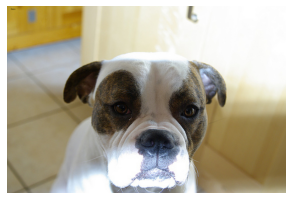

In [212]:
im0 = PILImage.create(files[0])
show_image(im0);

In [213]:
# Since transforms naturally apply across tuples, all we need to do here is inherit from the tuple class 
# and implement a show method for display purposes 
class SiameseImage(fastuple):
    def show(self, ctx=None, **kwargs):
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2=img1,img2        
        line = t1.new_zeros(t1.shape[0], t1.shape[1],10)
        return show_image(torch.cat([t1,line,t2], dim=2), title=same_breed,ctx=ctx)

In [214]:
isinstance(im0, Tensor)

False

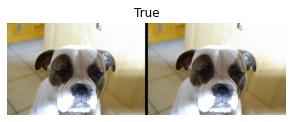

In [215]:
s = SiameseImage(im0,im0,True)
s.show();

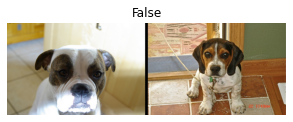

In [216]:
im1 = PILImage.create(files[1])
s1 = SiameseImage(im0,im1,False)
s1.show();

Transforms apply over all elements in tuples - that's wy we subclassed from tuple here. Now we can apply transformations to these stitched-together images! 

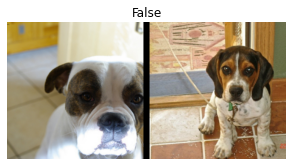

In [217]:
resized = Resize(224)(s1)
resized.show();

Resize is applied to the images, but not the boolean, because transforms are smart like that - they apply to every item in the tuple, as long as the value is of a type that can be transformed. 

Now we can define a custom function which will get the correct label for us. It should be true if the animals have the same breed, and false if not. It just gets the text before the underscore and digit, which in the filename is always the breed of animal 

In [218]:
def label_func(filename):
    return re.match(r'^(.*)_\d+.jpg', filename.name).groups()[0]

In [219]:
files.map(label_func)[:20]

(#20) ['american_bulldog','beagle','Bengal','pug','Bombay','Persian','american_pit_bull_terrier','Bengal','Abyssinian','pomeranian'...]

In [220]:
import random 
# Define a custom transform for building the pairs of images 
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        # get all the unique labels in the files 
        self.labels = files.map(label_func).unique()
        # map each label back to its set of files (e.g. all american bulldog file paths) 
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) for l in self.labels}
        self.label_func = label_func
        # draw each of the validation pairs in advance 
        self.valid = {f: self._draw(f) for f in files[splits[1]]}
    
    def encodes(self,f):
        # take the pair from the pre-computed validation values if exists, else default to drawing again 
        # (i.e. for training samples)          
        f2, same = self.valid.get(f, self._draw(f))
        im1,im2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(im1,im2,same)
    
    def _draw(self,f):
        """
        randomly choose a siamese pair for f
        with P(0.5) choose a random file of the same breed
        with P(0.5) choose a random file of different breed
        """
        same = random.random() < 0.5
        cls = self.label_func(f) 
        if not same:
            # find a random different breed class
            cls = random.choice(L(l for l in self.labels if l != cls))
        return random.choice(self.lbl2files[cls]), same        

In [221]:
RandomSplitter??

Signature: RandomSplitter(valid_pct=0.2, seed=None)
Source:   
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = L(list(torch.randperm(len(o)).numpy()))
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
File:      /opt/conda/lib/python3.7/site-packages/fastai/data/transforms.py
Type:      function


In [222]:
splits = RandomSplitter()(files) 
splits

((#5912) [529,385,4830,6504,4907,1713,94,43,6629,4476...],
 (#1478) [6438,4304,2537,1247,1804,2395,6309,577,1060,2034...])

In [223]:
tfm = SiameseTransform(files, label_func,splits)

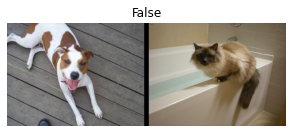

In [224]:
img = tfm(files[2582])
img.show();

In [225]:
tls = TfmdLists(files, tfm, splits=splits) 

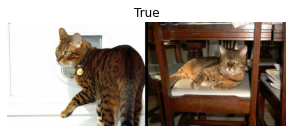

In [226]:
tls.valid[0].show();

In [227]:
dls = tls.dataloaders(after_item=[Resize(224),ToTensor], after_batch=[IntToFloatTensor,Normalize.from_stats(*imagenet_stats)])

In [228]:
ds = dls.valid.dataset

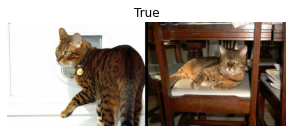

In [231]:
ds[0].show();